In [1]:
import pandas
import konlpy
import gensim
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [2]:
# 데이터 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) 데이터로더 구성
데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
import os
import pandas
import konlpy
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.initializers import Constant

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000
def load_data(train_data, test_data, num_words=num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist] 
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# ex) 최대 길이를 (평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함


In [7]:
#패딩 추가(pre)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [8]:
vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,), trainable=True)) 
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.GlobalMaxPooling1D()) 
model.add(tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.2))) # LeakyReLU 사용 
model.add(tf.keras.layers.Dropout(0.2)) 
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
__________________________________________________

In [9]:
vocab_size_1 = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim_1 = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size_1, word_vector_dim_1, input_shape=(None,)))
model_1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(tf.keras.layers.MaxPooling1D(5))
model_1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(tf.keras.layers.GlobalMaxPooling1D())
model_1.add(tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [10]:
vocab_size_2 = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim_2 = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size_2, word_vector_dim_2, input_shape=(None,)))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [27]:
#훈련 개시
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 4ms/step - loss: 0.3142 - accuracy: 0.8676 - val_loss: 0.3843 - val_accuracy: 0.8381
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3139 - accuracy: 0.8672 - val_loss: 0.3842 - val_accuracy: 0.8389
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3130 - accuracy: 0.8693 - val_loss: 0.3843 - val_accuracy: 0.8383
Epoch 4/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3132 - accuracy: 0.8682 - val_loss: 0.3847 - val_accuracy: 0.8378
Epoch 5/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3124 - accuracy: 0.8684 - val_loss: 0.3863 - val_accuracy: 0.8387


In [25]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3945 - accuracy: 0.8342
[0.3945266008377075, 0.8342453837394714]


In [17]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1 = model_1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results_1 = model_1.evaluate(x_test,  y_test, verbose=2)
history_dict_1 = history_1.history

results_1

Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.6793 - accuracy: 0.5646 - val_loss: 0.6823 - val_accuracy: 0.5637
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6791 - accuracy: 0.5660 - val_loss: 0.6842 - val_accuracy: 0.5529
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6788 - accuracy: 0.5662 - val_loss: 0.6817 - val_accuracy: 0.5656
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6787 - accuracy: 0.5657 - val_loss: 0.6819 - val_accuracy: 0.5641
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6783 - accuracy: 0.5668 - val_loss: 0.6819 - val_accuracy: 0.5651
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6781 - accuracy: 0.5677 - val_loss: 0.6818 - val_accuracy: 0.5664
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6780 - accuracy: 0.5679 - val_loss: 0.6820 - val_accuracy: 0.5642
Epoch 

[0.6859973073005676, 0.552922248840332]

In [21]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_2= model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results_2 = model_2.evaluate(x_test,  y_test, verbose=2)
history_dict_2 = history_2.history

results_2

Epoch 1/10
266/266 [==============================] - 2s 4ms/step - loss: 0.6881 - accuracy: 0.5453 - val_loss: 0.6872 - val_accuracy: 0.5446
Epoch 2/10
266/266 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5455 - val_loss: 0.6872 - val_accuracy: 0.5431
Epoch 3/10
266/266 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5460 - val_loss: 0.6873 - val_accuracy: 0.5446
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.6880 - accuracy: 0.5462 - val_loss: 0.6873 - val_accuracy: 0.5448
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.6880 - accuracy: 0.5458 - val_loss: 0.6872 - val_accuracy: 0.5431
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.6880 - accuracy: 0.5458 - val_loss: 0.6872 - val_accuracy: 0.5421
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.6879 - accuracy: 0.5463 - val_loss: 0.6873 - val_accuracy: 0.5436
Epoch 

[0.6886586546897888, 0.5413877964019775]

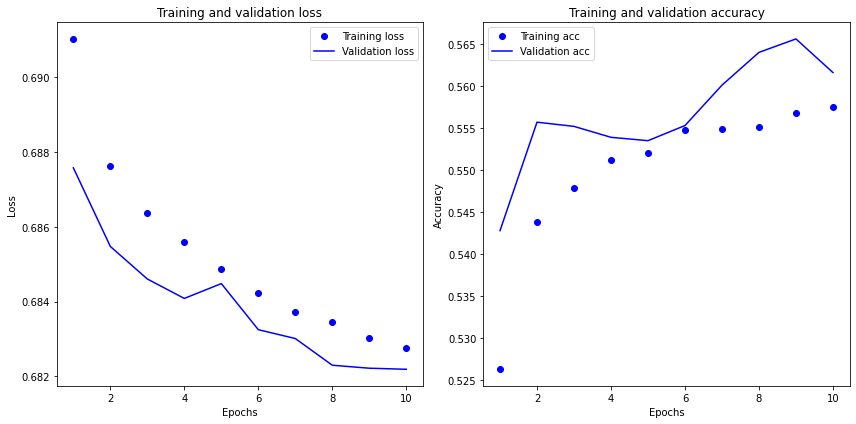

In [28]:
#Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Training and validation loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


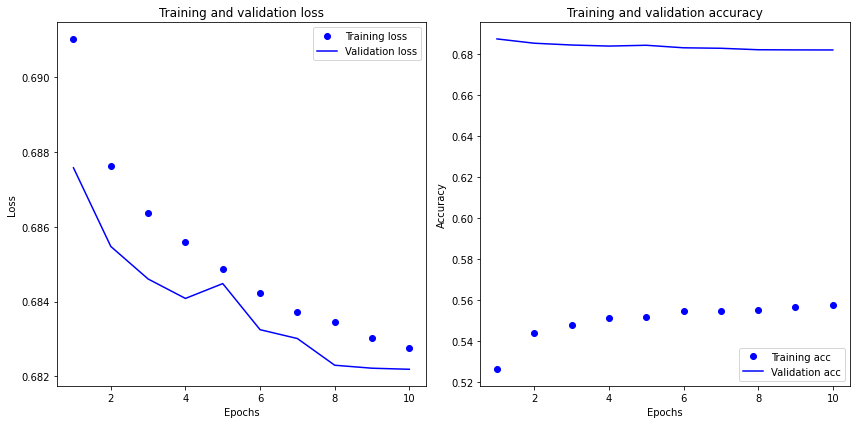

In [29]:
acc_1 = history_dict['accuracy']
val_acc_1 = history_dict['val_accuracy']
loss_1 = history_dict['loss']
val_loss_1 = history_dict['val_loss']

epochs_1 = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Training and validation loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_1, loss_1, 'bo', label='Training loss')
plt.plot(epochs_1, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_1, acc_1, 'bo', label='Training acc')
plt.plot(epochs_1, val_loss_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

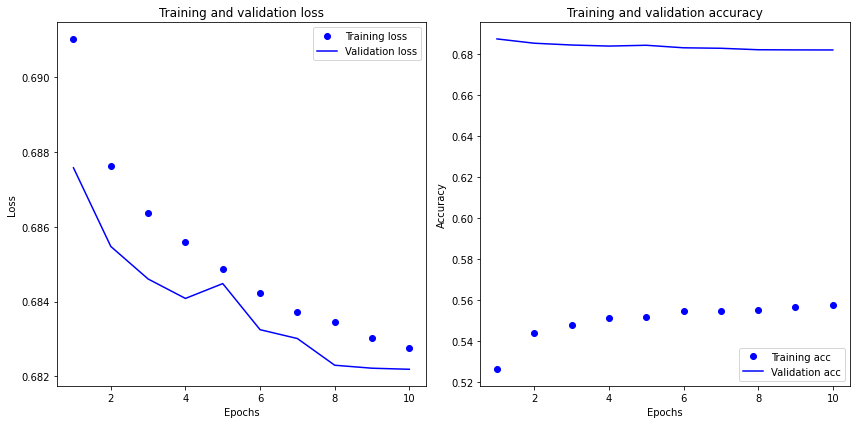

In [30]:
acc_2 = history_dict['accuracy']
val_acc_2 = history_dict['val_accuracy']
loss_2 = history_dict['loss']
val_loss_2 = history_dict['val_loss']

epochs_2 = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Training and validation loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_2, loss_2, 'bo', label='Training loss')
plt.plot(epochs_2, val_loss_2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_2, acc_2, 'bo', label='Training acc')
plt.plot(epochs_2, val_loss_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
#학습된 Embedding 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [32]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_exp4.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [34]:
vector = word_vectors['심']
vector

array([-0.00419781,  0.24228024, -0.02989314,  0.06533517, -0.01560549,
       -0.00457291, -0.00102867, -0.01094859, -0.0025065 , -0.04232293,
       -0.04622766, -0.00499826, -0.04565343, -0.02443086, -0.00290714,
       -0.00217956], dtype=float32)

In [36]:
word_vectors.similar_by_word("에휴")

[('그만', 0.9166591763496399),
 ('맞', 0.8949285745620728),
 ('미스터리', 0.878200888633728),
 ('날개', 0.8672823905944824),
 ('상관없이', 0.8619695901870728),
 ('cm', 0.8579860329627991),
 ('뻘', 0.856236457824707),
 ('악어', 0.8486582040786743),
 ('김혜선', 0.8486297130584717),
 ('토비', 0.848613440990448)]

In [ ]:
!

In [43]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = 'word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)

In [44]:
import numpy as np
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [45]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 9s 12ms/step - loss: 0.4612 - accuracy: 0.7776 - val_loss: 0.3759 - val_accuracy: 0.8309
Epoch 2/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3427 - accuracy: 0.8491 - val_loss: 0.3309 - val_accuracy: 0.8514
Epoch 3/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2975 - accuracy: 0.8723 - val_loss: 0.3171 - val_accuracy: 0.8588
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2696 - accuracy: 0.8865 - val_loss: 0.3212 - val_accuracy: 0.8633
Epoch 5/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2451 - accuracy: 0.8983 - val_loss: 0.3207 - val_accuracy: 0.8611
Epoch 6/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2255 - accuracy: 0.9076 - val_loss: 0.3192 - val_accuracy: 0.8640
Epoch 7/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2031 - accuracy: 0.9184 - val_loss: 0.3360 - val_accuracy: 0.8617

In [47]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3974 - accuracy: 0.8582
[0.3974064886569977, 0.858189046382904]


In [48]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


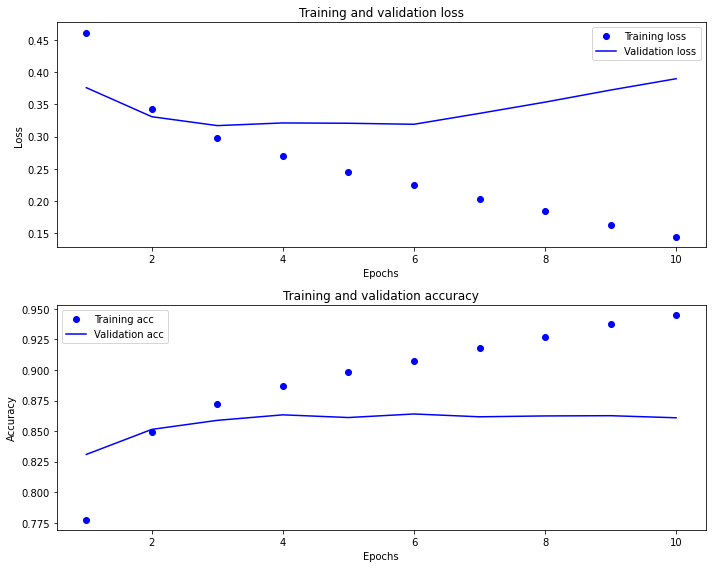

In [49]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 두 개의 축 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 플롯: Loss
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 두 번째 플롯: Accuracy
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()  # 축간 간격 조정
plt.show()